# Visualización de precios en Bolivia

In [413]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
import datetime as dt
from textwrap import wrap
from IPython import display

plt.style.use('publish/estilo.mplstyle')
pd.options.display.max_rows = 500

In [161]:
def format_ipc(excel, sheet):
    df = pd.read_excel(ipc, sheet, engine='openpyxl')
    df.columns = df.iloc[3]
    df = df.iloc[6:-1]
    df = df.melt(['CÓDIGO', 'DESCRIPCIÓN'], var_name='fecha', value_name='ipc')
    df['fecha'] = pd.to_datetime(df.fecha)
    df['ipc'] = df.ipc.astype(float)
    df.columns = ['codigo', 'nombre', 'fecha', 'ipc']
    df.insert(0, 'ciudad', sheet)
    return df

def get_categoria(codigo):
    categorias = {
        '01': 'alimentos y bebidas no alcohólicas',
        '02': 'bebidas alcohólicas y tabaco',
        '03': 'prendas de vestir y calzado',
        '04': 'vivienda y servicios básicos',
        '05': 'muebles, bienes y servicios domésticos',
        '06': 'salud',
        '07': 'transporte',
        '08': 'comunicaciones',
        '09': 'recreación y cultura',
        '10': 'educación',
        '11': 'alimentos y bebidas consumidos fuera del hogar',
        '12': 'bienes y servicios diversos'
    }
    
    return categorias[str(codigo).strip()[:2]]

In [427]:
excel = pd.ExcelFile('data/Ciu-2021_11_6_IPC_Producto.xlsx', engine='openpyxl')
df = pd.concat([format_ipc(excel, sheet) for sheet in excel.sheet_names[1:]], axis=0)
df['categoria'] = df.codigo.apply(get_categoria)
productos = pd.concat([df.groupby('codigo')[['nombre', 'categoria']].first(), pd.Series({i: len(dfi) for i, dfi in df.groupby('codigo').ciudad.unique().iteritems()})], axis=1).rename(columns={0: 'ciudades'})

In [438]:
display.Markdown('Una visualización del valor relativo de precios en el Índice de Precios al Consumidor entre 2018 y Noviembre de 2021. Incluye sólo valores mensuales para productos presentes en todos los departamentos, que representan el {:.0%} de productos en el Índice y {:.0%} de las observaciones registradas. Los productos están agrupados en categorías para facilitar su interpretación. Colores más claros y oscuros representan precios más altos y bajos respectivamente.'.format(productos.ciudades.value_counts(normalize=True).to_dict()[9], df.codigo.isin(productos[productos.ciudades == 9].index).sum() / len(df)))

Una visualización del valor relativo de precios en el Índice de Precios al Consumidor entre 2018 y Noviembre de 2021. Incluye sólo valores mensuales para productos presentes en todos los departamentos, que representan el 35% de productos en el Índice y 53% de las observaciones registradas. Los productos están agrupados en categorías para facilitar su interpretación. Colores más claros y oscuros representan precios más altos y bajos respectivamente.

In [ ]:
def caption(text, filename):
    display(Markdown('<p class="caption"> <em>{} (<a href="https://github.com/mauforonda/notas/raw/main/{}">imagen en alta resolución</a>) </em> </p>'.format(text, filename)))

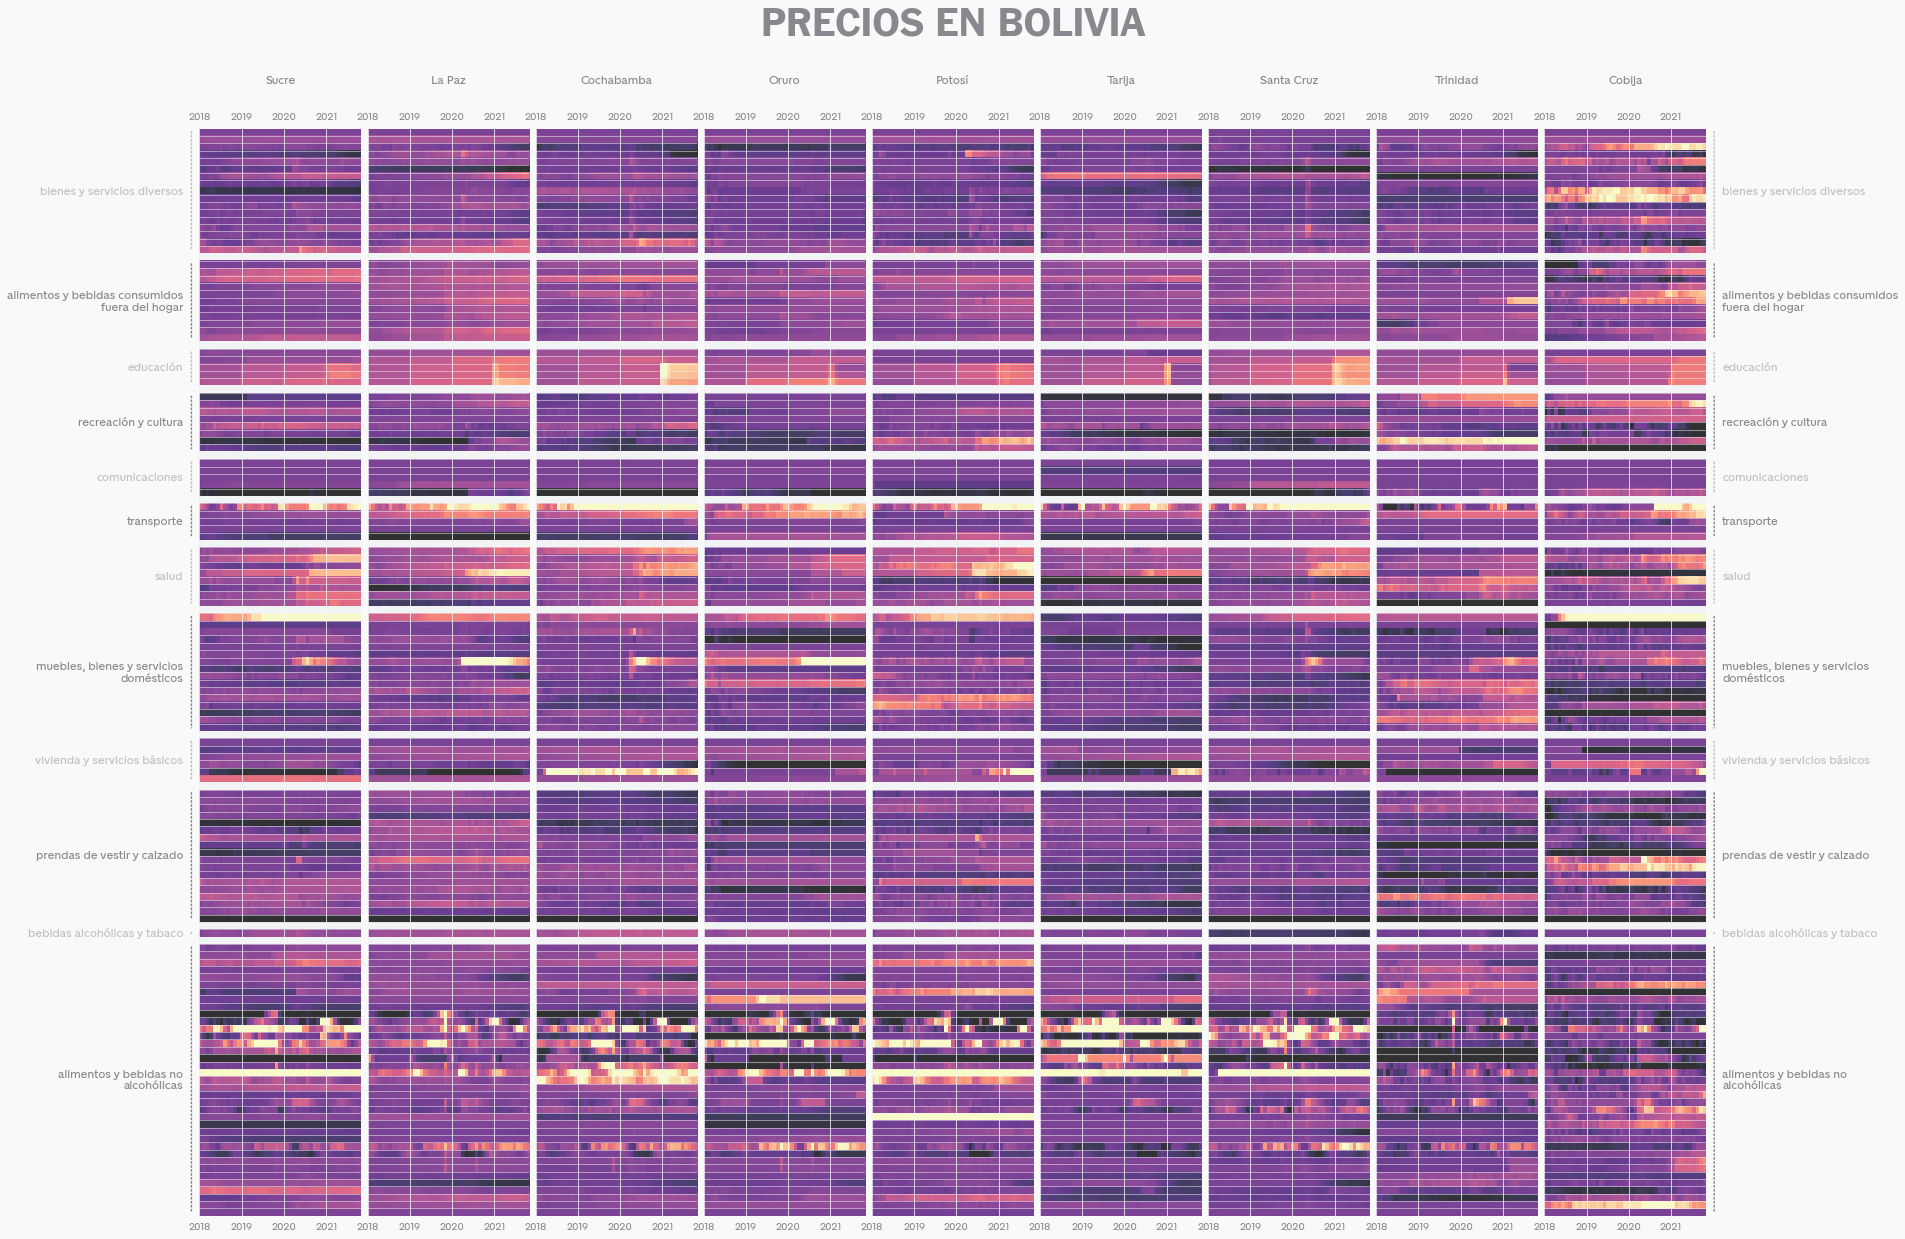

<p class="caption"> <em>Precios en Bolivia (<a href="https://github.com/mauforonda/notas/raw/main/plots/precios_en_bolivia.png">imagen en alta resolución</a>) </em> </p>

In [449]:
def plot_ipc(n):
    
    def make_cuadro_index(filtro, categoria_count):
        stops = pd.Series([categoria_count[i] for i in categoria_count.keys()]).cumsum().tolist()
        n = len(stops)
        cuadro_index = []
        start = 0
        for i, end in enumerate(stops):
            chunk = filtro.index[start:end].tolist()
            cuadro_index.extend(chunk)
            if i != n-1:
                cuadro_index.append(filtro.index[end] + 'a')
            start = end
            i += 1
        return cuadro_index
    
    ciudades = {
        'Sucre': 'Sucre',
        'Conurbación La Paz': 'La Paz',
        'Región Metropolitana Kanata': 'Cochabamba',
        'Oruro': 'Oruro',
        'Potosí': 'Potosí',
        'Tarija': 'Tarija',
        'Conurbación Santa Cruz': 'Santa Cruz',
        'Trinidad': 'Trinidad',
        'Cobija': 'Cobija'
    }
    
    lincolor = '#88888f'

    f, axs = plt.subplots(1,n,figsize=(n * 3, 20), sharey=True)
    plt.subplots_adjust(wspace=.04)
    filtro = productos[productos.ciudades == 9].sort_index()
    categoria_count = filtro.categoria.value_counts().to_dict()
    categoria_count = {i: categoria_count[i] for i in filtro.categoria.unique()}
    cuadro_index = make_cuadro_index(filtro, categoria_count)

    for ax, ciudad in zip(axs, list(df.ciudad.unique())[:n]):
        
        dfi = df[df.ciudad == ciudad].pivot_table(index='codigo', columns='fecha', values='ipc').loc[filtro.index]
        dfi = pd.concat([pd.Series(index=cuadro_index, dtype=float), dfi], axis=1).drop(columns=[0])
        dfi.columns = dates.date2num(dfi.columns)
        
        ax.imshow(dfi, cmap='magma', alpha=.8, aspect='auto', vmin=80, vmax=150, extent=[dfi.columns[0], dfi.columns[-1], 0, len(dfi)], zorder=1, origin='lower')
        
        ax.xaxis_date()
        ax.xaxis.set_major_locator(dates.YearLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
        ax.tick_params(labeltop=True, labelleft=False, labelcolor=lincolor, labelsize=10)
        ax.grid(b=True, axis='x', linewidth=.8, linestyle='-', color='#f2f3f5', zorder=2, alpha=1.)
        ax.yaxis.set_minor_locator(ticker.FixedLocator(list(range(len(dfi)))))
        ax.grid(b=True, which='minor', axis='y', linewidth=.5, linestyle='-', color='#f2f3f5', zorder=2, alpha=1.)
        ax.annotate(ciudades[ciudad], xy=(.5, 1.04), xycoords='axes fraction', color=lincolor, ha='center', va='bottom', fontsize=12)
        
        
    for i, linepad, textpad, textdir in zip([0, -1], [-.05, 1.05], [-.1, 1.1], ['right', 'left']):
        
        top = 0
        length = len(filtro) + len(categoria_count.keys()) - 1
        soft = False
        for cat in categoria_count.keys():
            axs[i].annotate("", xy=(linepad, (top/length) + .001), xycoords='axes fraction', xytext=(linepad, ((top + categoria_count[cat]) / length) - .001), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=lincolor, linewidth=1.5, linestyle=':', alpha=.5 if soft else 1.))
            axs[i].annotate('\n'.join(wrap(cat, 30)), xy=(textpad, (top + (categoria_count[cat] / 2)) / length), xycoords='axes fraction', ha=textdir, va='center', color=lincolor, alpha=.5 if soft else 1., fontsize=12)
            top += categoria_count[cat] + 1
            soft = not soft
      
    title_position = n / 2
    axs[round(title_position)].annotate('Precios en Bolivia'.upper(), xy=(title_position - round(title_position), 1.08), xycoords='axes fraction', color=lincolor, ha='center', va='bottom', fontsize=40, fontfamily='NYTFranklin', fontweight='bold')
    
    filename = 'plots/precios_en_bolivia.png'
    f.savefig(filename, bbox_inches='tight', pad_inches=.4, dpi=200)
    plt.show()
    display.display(display.Markdown('<p class="caption"> <em>Precios en Bolivia (<a href="https://github.com/mauforonda/notas/raw/main/{}">imagen en alta resolución</a>) </em> </p>'.format(filename)))
    
plot_ipc(9)